# Wine Dimensional Reduction
_Herman Dempere Guillermo_

The objective of this notebook is to find wether we can express the multitude of style names in fewer dimensions while still keeping most of the data's variability. Our incoming data is one-hot encoded, which is a binary representation. Our output is ging to be n-dimensional continuous variables.

The ideal outcome is that we can represent the many styles that reviewers use for describing the wines with as few continous dimensions as possible. A good target is between 6 and 12. This makes it possible to graph a "general wine representation" in the shape of a radar plot.

## Data Loading and Cleaning

In [72]:
import pandas as pd
import numpy as np

In [73]:
df = pd.read_excel('CBR_OneHot.xlsx')
df.head(1)

,id,name_no_year,price,points,tinto,blanco,tinto crianza,rosado,blanco espumoso brut nature reserva,blanco espumoso brut nature gran reserva,...,2011,2010,2009,2008,2007,2006,2005,2004,2000,ecologic
0,serra_de_cavalls_garnacha_blanca_2021_b,Serra de Cavalls Garnacha Blanca,5.8,86,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
df_style = df[[
    "id","corpulento","sabroso","frutal","equilibrado","cítrico","especiado","suave","herbal","persistente","floral","fresco","tostado","correcto","amargo","aromático","dulce","notas de levadura","oxidado","silvestre","balsámico","con defectos","taninos","elegante","con vejez","cálido","mineral","tropical","varietal","clásico","carnoso","cremoso","rústico"
]]

# Group by ID and cap to value 1 (report mistake to Marc)
df_style = df_style.groupby('id').max()
df_style[df_style > 1] = 1

# Delete wines without any style information
df_style['count'] = df_style.sum(axis=1)
df_style = df_style[df_style['count'] > 0]
del df_style['count']

df_style.head(3)

,corpulento,sabroso,frutal,equilibrado,cítrico,especiado,suave,herbal,persistente,floral,...,elegante,con vejez,cálido,mineral,tropical,varietal,clásico,carnoso,cremoso,rústico
id,,,,,,,,,,,,,,,,,,,,,
10000_hores_floral_2020_b,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10000_hores_negre_seleccio_2019_t,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000_hores_rose_2020_rd,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Attempt 1: PCA

In [75]:
from sklearn.decomposition import PCA

for i in range(4, df_style.shape[1]+1, 2):
    pca = PCA(n_components=i, svd_solver='full')
    df_pca = pca.fit_transform(df_style)
    pd.DataFrame(data=df_pca)
    
    print('n_components =',i, '\texplained var:', sum(pca.explained_variance_ratio_))


n_components = 4 	explained var: 0.4146160974068799
n_components = 6 	explained var: 0.5467035840006643
n_components = 8 	explained var: 0.6482789371925141
n_components = 10 	explained var: 0.7271982758418053
n_components = 12 	explained var: 0.7938629469853269
n_components = 14 	explained var: 0.846335215112811
n_components = 16 	explained var: 0.8871883042824283
n_components = 18 	explained var: 0.9194134078540147
n_components = 20 	explained var: 0.9430629633613403
n_components = 22 	explained var: 0.9626018466402348
n_components = 24 	explained var: 0.9748412074986108
n_components = 26 	explained var: 0.9851272708699543
n_components = 28 	explained var: 0.9928854797837503
n_components = 30 	explained var: 0.9972390548301959
n_components = 32 	explained var: 0.9999999999999998


**PCA Conclusions:**

We find that we need to use too many components (up to 18) to reach 90% explained variability (and thus having a relevant low-dimensional representation of each wine.

For now we will keep searching for a better method. However this sets a benchmark of what can be achieved in terms of dim-reduction.

## Attempt 2: Autoencoder

In [76]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers
from keras import backend as K
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

In [77]:
n_total = df_style.shape[0]
n_test_cutoff = int(n_total*0.90)
x_train = df_style[:n_test_cutoff]
x_test = df_style[n_test_cutoff:]

len(x_train), len(x_test)

(2453, 273)

In [92]:
data_dim = df_style.shape[1]
encoding_dim = 5
my_regularizer = regularizers.l1(10e-8)


# in 32 > relu 20 > (sigmoid 5) > relu 20 > out sigmoid 32 

# Autoencoder model
input_layer = Input(shape=(data_dim, ))
hidden_1 = Dense(encoding_dim*4, activation='relu')(input_layer)
                                                    
encoded = Dense(encoding_dim, activation='sigmoid', activity_regularizer=my_regularizer)(hidden_1)

hidden_2 = Dense(encoding_dim*4, activation='relu')(encoded)
decoded = Dense(data_dim, activation='sigmoid')(hidden_2)

autoencoder = Model(input_layer, decoded)

# ENCODER
encoder = Model(input_layer, encoded)

# DECODER
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
hidden_layer_2 = autoencoder.layers[-2]
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(hidden_layer_2(encoded_input)))

es = EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min")

# Train to reconstruct Styles
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
hist = autoencoder.fit(x_train, x_train, epochs=5000, batch_size=256, shuffle=True,
                       validation_data=(x_test, x_test), verbose=1, callbacks=[es,])


Epoch 1/5000
10/10 [==============================] - 0s 13ms/step - loss: 0.6954 - val_loss: 0.6838
Epoch 2/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.6764 - val_loss: 0.6653
Epoch 3/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.6580 - val_loss: 0.6465
Epoch 4/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.6387 - val_loss: 0.6258
Epoch 5/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.6170 - val_loss: 0.6021
Epoch 6/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.5921 - val_loss: 0.5752
Epoch 7/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.5641 - val_loss: 0.5453
Epoch 8/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.5329 - val_loss: 0.5126
Epoch 9/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.4995 - val_loss: 0.4785
Epoch 10/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.4658 - val_loss: 0.445

10/10 [==============================] - 0s 3ms/step - loss: 0.2208 - val_loss: 0.2242
Epoch 83/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.2199 - val_loss: 0.2234
Epoch 84/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.2190 - val_loss: 0.2226
Epoch 85/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2182 - val_loss: 0.2218
Epoch 86/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.2173 - val_loss: 0.2210
Epoch 87/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2165 - val_loss: 0.2202
Epoch 88/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.2156 - val_loss: 0.2195
Epoch 89/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.2147 - val_loss: 0.2186
Epoch 90/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.2139 - val_loss: 0.2178
Epoch 91/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.2129 - val_loss: 0.2169
Epoc

10/10 [==============================] - 0s 4ms/step - loss: 0.1669 - val_loss: 0.1734
Epoch 163/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1666 - val_loss: 0.1731
Epoch 164/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1664 - val_loss: 0.1728
Epoch 165/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1661 - val_loss: 0.1725
Epoch 166/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1659 - val_loss: 0.1723
Epoch 167/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1656 - val_loss: 0.1721
Epoch 168/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1654 - val_loss: 0.1718
Epoch 169/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1651 - val_loss: 0.1716
Epoch 170/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1649 - val_loss: 0.1713
Epoch 171/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1646 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.1512 - val_loss: 0.1577
Epoch 243/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1511 - val_loss: 0.1577
Epoch 244/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1510 - val_loss: 0.1575
Epoch 245/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1508 - val_loss: 0.1574
Epoch 246/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1507 - val_loss: 0.1572
Epoch 247/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1505 - val_loss: 0.1569
Epoch 248/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1504 - val_loss: 0.1569
Epoch 249/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1503 - val_loss: 0.1568
Epoch 250/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1502 - val_loss: 0.1566
Epoch 251/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1500 - val_loss: 0.

10/10 [==============================] - 0s 3ms/step - loss: 0.1423 - val_loss: 0.1484
Epoch 323/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1422 - val_loss: 0.1483
Epoch 324/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1421 - val_loss: 0.1482
Epoch 325/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1421 - val_loss: 0.1482
Epoch 326/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1420 - val_loss: 0.1480
Epoch 327/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1419 - val_loss: 0.1480
Epoch 328/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1418 - val_loss: 0.1479
Epoch 329/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1417 - val_loss: 0.1476
Epoch 330/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1416 - val_loss: 0.1477
Epoch 331/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1415 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.1367 - val_loss: 0.1427
Epoch 403/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1367 - val_loss: 0.1429
Epoch 404/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1366 - val_loss: 0.1428
Epoch 405/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1366 - val_loss: 0.1428
Epoch 406/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1366 - val_loss: 0.1427
Epoch 407/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1365 - val_loss: 0.1425
Epoch 408/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1364 - val_loss: 0.1426
Epoch 409/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1364 - val_loss: 0.1426
Epoch 410/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1363 - val_loss: 0.1425
Epoch 411/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1363 - val_loss: 0.

10/10 [==============================] - 0s 3ms/step - loss: 0.1334 - val_loss: 0.1398
Epoch 483/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1334 - val_loss: 0.1398
Epoch 484/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1334 - val_loss: 0.1398
Epoch 485/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1334 - val_loss: 0.1398
Epoch 486/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1334 - val_loss: 0.1399
Epoch 487/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1334 - val_loss: 0.1397
Epoch 488/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1332 - val_loss: 0.1397
Epoch 489/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1332 - val_loss: 0.1399
Epoch 490/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1332 - val_loss: 0.1400
Epoch 491/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1332 - val_loss: 0.

10/10 [==============================] - 0s 3ms/step - loss: 0.1313 - val_loss: 0.1375
Epoch 563/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1313 - val_loss: 0.1376
Epoch 564/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1312 - val_loss: 0.1375
Epoch 565/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1312 - val_loss: 0.1375
Epoch 566/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1312 - val_loss: 0.1375
Epoch 567/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1312 - val_loss: 0.1375
Epoch 568/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1312 - val_loss: 0.1375
Epoch 569/5000
10/10 [==============================] - 0s 5ms/step - loss: 0.1311 - val_loss: 0.1375
Epoch 570/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1311 - val_loss: 0.1373
Epoch 571/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1311 - val_loss: 0.

10/10 [==============================] - 0s 3ms/step - loss: 0.1297 - val_loss: 0.1359
Epoch 643/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.1359
Epoch 644/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1296 - val_loss: 0.1359
Epoch 645/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.1359
Epoch 646/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.1358
Epoch 647/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.1358
Epoch 648/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1295 - val_loss: 0.1358
Epoch 649/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1295 - val_loss: 0.1358
Epoch 650/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1295 - val_loss: 0.1358
Epoch 651/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1295 - val_loss: 0.

10/10 [==============================] - 0s 3ms/step - loss: 0.1281 - val_loss: 0.1344
Epoch 723/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1281 - val_loss: 0.1345
Epoch 724/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1281 - val_loss: 0.1344
Epoch 725/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1281 - val_loss: 0.1344
Epoch 726/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1281 - val_loss: 0.1344
Epoch 727/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1281 - val_loss: 0.1343
Epoch 728/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1281 - val_loss: 0.1344
Epoch 729/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1281 - val_loss: 0.1344
Epoch 730/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1281 - val_loss: 0.1345
Epoch 731/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1280 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.1268 - val_loss: 0.1332
Epoch 803/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1268 - val_loss: 0.1333
Epoch 804/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1268 - val_loss: 0.1333
Epoch 805/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1268 - val_loss: 0.1334
Epoch 806/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1268 - val_loss: 0.1332
Epoch 807/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1268 - val_loss: 0.1332
Epoch 808/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1268 - val_loss: 0.1332
Epoch 809/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1267 - val_loss: 0.1331
Epoch 810/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1267 - val_loss: 0.1332
Epoch 811/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1267 - val_loss: 0.

10/10 [==============================] - 0s 4ms/step - loss: 0.1255 - val_loss: 0.1323
Epoch 883/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1255 - val_loss: 0.1321
Epoch 884/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1254 - val_loss: 0.1322
Epoch 885/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1255 - val_loss: 0.1322
Epoch 886/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1254 - val_loss: 0.1322
Epoch 887/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1254 - val_loss: 0.1321
Epoch 888/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1254 - val_loss: 0.1321
Epoch 889/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1254 - val_loss: 0.1322
Epoch 890/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1254 - val_loss: 0.1322
Epoch 891/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1254 - val_loss: 0.

10/10 [==============================] - 0s 3ms/step - loss: 0.1242 - val_loss: 0.1313
Epoch 963/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1242 - val_loss: 0.1312
Epoch 964/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1242 - val_loss: 0.1314
Epoch 965/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1242 - val_loss: 0.1313
Epoch 966/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1242 - val_loss: 0.1313
Epoch 967/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1242 - val_loss: 0.1313
Epoch 968/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1242 - val_loss: 0.1314
Epoch 969/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1241 - val_loss: 0.1313
Epoch 970/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1241 - val_loss: 0.1312
Epoch 971/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1241 - val_loss: 0.

10/10 [==============================] - 0s 3ms/step - loss: 0.1229 - val_loss: 0.1303
Epoch 1043/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1229 - val_loss: 0.1304
Epoch 1044/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1229 - val_loss: 0.1304
Epoch 1045/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1229 - val_loss: 0.1303
Epoch 1046/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1228 - val_loss: 0.1304
Epoch 1047/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1304
Epoch 1048/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1303
Epoch 1049/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1303
Epoch 1050/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1228 - val_loss: 0.1303
Epoch 1051/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1228 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.1216 - val_loss: 0.1297
Epoch 1122/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1216 - val_loss: 0.1298
Epoch 1123/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1216 - val_loss: 0.1296
Epoch 1124/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1215 - val_loss: 0.1296
Epoch 1125/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1215 - val_loss: 0.1296
Epoch 1126/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1216 - val_loss: 0.1298
Epoch 1127/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1215 - val_loss: 0.1297
Epoch 1128/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1215 - val_loss: 0.1297
Epoch 1129/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1215 - val_loss: 0.1296
Epoch 1130/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1214 - val

10/10 [==============================] - 0s 3ms/step - loss: 0.1203 - val_loss: 0.1289
Epoch 1201/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1203 - val_loss: 0.1291
Epoch 1202/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1203 - val_loss: 0.1290
Epoch 1203/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1203 - val_loss: 0.1292
Epoch 1204/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1203 - val_loss: 0.1291
Epoch 1205/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1203 - val_loss: 0.1289
Epoch 1206/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1203 - val_loss: 0.1289
Epoch 1207/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1203 - val_loss: 0.1290
Epoch 1208/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1202 - val_loss: 0.1289
Epoch 1209/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1202 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.1192 - val_loss: 0.1283
Epoch 1280/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1191 - val_loss: 0.1283
Epoch 1281/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1191 - val_loss: 0.1284
Epoch 1282/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1191 - val_loss: 0.1284
Epoch 1283/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1191 - val_loss: 0.1283
Epoch 1284/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1190 - val_loss: 0.1283
Epoch 1285/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1190 - val_loss: 0.1283
Epoch 1286/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1190 - val_loss: 0.1283
Epoch 1287/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1190 - val_loss: 0.1283
Epoch 1288/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1190 - val

10/10 [==============================] - 0s 3ms/step - loss: 0.1180 - val_loss: 0.1279
Epoch 1359/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1180 - val_loss: 0.1278
Epoch 1360/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1180 - val_loss: 0.1279
Epoch 1361/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1180 - val_loss: 0.1277
Epoch 1362/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1180 - val_loss: 0.1277
Epoch 1363/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1179 - val_loss: 0.1278
Epoch 1364/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1179 - val_loss: 0.1276
Epoch 1365/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1179 - val_loss: 0.1277
Epoch 1366/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1179 - val_loss: 0.1278
Epoch 1367/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1179 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.1169 - val_loss: 0.1268
Epoch 1438/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1169 - val_loss: 0.1268
Epoch 1439/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1169 - val_loss: 0.1269
Epoch 1440/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1168 - val_loss: 0.1267
Epoch 1441/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1169 - val_loss: 0.1269
Epoch 1442/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1169 - val_loss: 0.1267
Epoch 1443/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1169 - val_loss: 0.1267
Epoch 1444/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1169 - val_loss: 0.1267
Epoch 1445/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1168 - val_loss: 0.1268
Epoch 1446/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1168 - val

10/10 [==============================] - 0s 3ms/step - loss: 0.1158 - val_loss: 0.1259
Epoch 1517/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1158 - val_loss: 0.1258
Epoch 1518/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1158 - val_loss: 0.1258
Epoch 1519/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1158 - val_loss: 0.1258
Epoch 1520/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1158 - val_loss: 0.1260
Epoch 1521/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1158 - val_loss: 0.1257
Epoch 1522/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1157 - val_loss: 0.1259
Epoch 1523/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1157 - val_loss: 0.1258
Epoch 1524/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1156 - val_loss: 0.1258
Epoch 1525/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1157 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.1147 - val_loss: 0.1249
Epoch 1596/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1146 - val_loss: 0.1250
Epoch 1597/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1147 - val_loss: 0.1249
Epoch 1598/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1147 - val_loss: 0.1248
Epoch 1599/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1146 - val_loss: 0.1250
Epoch 1600/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1146 - val_loss: 0.1250
Epoch 1601/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1146 - val_loss: 0.1248
Epoch 1602/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1146 - val_loss: 0.1249
Epoch 1603/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1146 - val_loss: 0.1248
Epoch 1604/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1146 - val

10/10 [==============================] - 0s 3ms/step - loss: 0.1136 - val_loss: 0.1239
Epoch 1675/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1136 - val_loss: 0.1240
Epoch 1676/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1135 - val_loss: 0.1239
Epoch 1677/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1136 - val_loss: 0.1238
Epoch 1678/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1135 - val_loss: 0.1238
Epoch 1679/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1135 - val_loss: 0.1237
Epoch 1680/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1135 - val_loss: 0.1239
Epoch 1681/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1135 - val_loss: 0.1239
Epoch 1682/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1135 - val_loss: 0.1237
Epoch 1683/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1135 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.1126 - val_loss: 0.1229
Epoch 1754/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1126 - val_loss: 0.1229
Epoch 1755/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1125 - val_loss: 0.1228
Epoch 1756/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1126 - val_loss: 0.1227
Epoch 1757/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1126 - val_loss: 0.1229
Epoch 1758/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1125 - val_loss: 0.1228
Epoch 1759/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1125 - val_loss: 0.1228
Epoch 1760/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1126 - val_loss: 0.1228
Epoch 1761/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1126 - val_loss: 0.1228
Epoch 1762/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1125 - val

10/10 [==============================] - 0s 3ms/step - loss: 0.1117 - val_loss: 0.1219
Epoch 1833/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1117 - val_loss: 0.1218
Epoch 1834/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1116 - val_loss: 0.1218
Epoch 1835/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1117 - val_loss: 0.1218
Epoch 1836/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1116 - val_loss: 0.1220
Epoch 1837/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1116 - val_loss: 0.1218
Epoch 1838/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1116 - val_loss: 0.1217
Epoch 1839/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1116 - val_loss: 0.1218
Epoch 1840/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1116 - val_loss: 0.1218
Epoch 1841/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1116 - val

10/10 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.1211
Epoch 1912/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.1210
Epoch 1913/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1109 - val_loss: 0.1210
Epoch 1914/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.1211
Epoch 1915/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.1210
Epoch 1916/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1108 - val_loss: 0.1209
Epoch 1917/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.1209
Epoch 1918/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1109 - val_loss: 0.1210
Epoch 1919/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1108 - val_loss: 0.1209
Epoch 1920/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1108 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.1101 - val_loss: 0.1201
Epoch 1991/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1101 - val_loss: 0.1201
Epoch 1992/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1101 - val_loss: 0.1202
Epoch 1993/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1101 - val_loss: 0.1202
Epoch 1994/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1101 - val_loss: 0.1202
Epoch 1995/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1101 - val_loss: 0.1202
Epoch 1996/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1101 - val_loss: 0.1201
Epoch 1997/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1100 - val_loss: 0.1201
Epoch 1998/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1100 - val_loss: 0.1202
Epoch 1999/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1100 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.1095 - val_loss: 0.1195
Epoch 2070/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.1194
Epoch 2071/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1095 - val_loss: 0.1193
Epoch 2072/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1094 - val_loss: 0.1193
Epoch 2073/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.1193
Epoch 2074/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.1194
Epoch 2075/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.1193
Epoch 2076/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1094 - val_loss: 0.1194
Epoch 2077/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1094 - val_loss: 0.1193
Epoch 2078/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1094 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.1089 - val_loss: 0.1187
Epoch 2149/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1088 - val_loss: 0.1187
Epoch 2150/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1089 - val_loss: 0.1187
Epoch 2151/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1089 - val_loss: 0.1190
Epoch 2152/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1089 - val_loss: 0.1188
Epoch 2153/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1088 - val_loss: 0.1189
Epoch 2154/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1089 - val_loss: 0.1189
Epoch 2155/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1088 - val_loss: 0.1187
Epoch 2156/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1088 - val_loss: 0.1186
Epoch 2157/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1088 - val

10/10 [==============================] - 0s 3ms/step - loss: 0.1083 - val_loss: 0.1182
Epoch 2228/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1084 - val_loss: 0.1181
Epoch 2229/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1083 - val_loss: 0.1181
Epoch 2230/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1083 - val_loss: 0.1180
Epoch 2231/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1083 - val_loss: 0.1179
Epoch 2232/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1083 - val_loss: 0.1180
Epoch 2233/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1083 - val_loss: 0.1180
Epoch 2234/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1083 - val_loss: 0.1180
Epoch 2235/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1082 - val_loss: 0.1180
Epoch 2236/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1082 - val

10/10 [==============================] - 0s 3ms/step - loss: 0.1078 - val_loss: 0.1174
Epoch 2307/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1079 - val_loss: 0.1174
Epoch 2308/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1078 - val_loss: 0.1175
Epoch 2309/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1078 - val_loss: 0.1174
Epoch 2310/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1078 - val_loss: 0.1173
Epoch 2311/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1078 - val_loss: 0.1173
Epoch 2312/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1078 - val_loss: 0.1174
Epoch 2313/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1078 - val_loss: 0.1174
Epoch 2314/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1078 - val_loss: 0.1173
Epoch 2315/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1078 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.1074 - val_loss: 0.1168
Epoch 2386/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1074 - val_loss: 0.1169
Epoch 2387/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1074 - val_loss: 0.1170
Epoch 2388/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1074 - val_loss: 0.1169
Epoch 2389/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1074 - val_loss: 0.1169
Epoch 2390/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1074 - val_loss: 0.1167
Epoch 2391/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1074 - val_loss: 0.1167
Epoch 2392/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1074 - val_loss: 0.1168
Epoch 2393/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1074 - val_loss: 0.1167
Epoch 2394/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1073 - val

10/10 [==============================] - 0s 3ms/step - loss: 0.1070 - val_loss: 0.1162
Epoch 2465/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1070 - val_loss: 0.1165
Epoch 2466/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1071 - val_loss: 0.1164
Epoch 2467/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1070 - val_loss: 0.1164
Epoch 2468/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1070 - val_loss: 0.1163
Epoch 2469/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1070 - val_loss: 0.1162
Epoch 2470/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1070 - val_loss: 0.1160
Epoch 2471/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1070 - val_loss: 0.1161
Epoch 2472/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1070 - val_loss: 0.1161
Epoch 2473/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1069 - val

10/10 [==============================] - 0s 3ms/step - loss: 0.1066 - val_loss: 0.1156
Epoch 2544/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1065 - val_loss: 0.1156
Epoch 2545/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1065 - val_loss: 0.1154
Epoch 2546/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1066 - val_loss: 0.1155
Epoch 2547/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1065 - val_loss: 0.1156
Epoch 2548/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1066 - val_loss: 0.1154
Epoch 2549/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1065 - val_loss: 0.1156
Epoch 2550/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1065 - val_loss: 0.1156
Epoch 2551/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1065 - val_loss: 0.1155
Epoch 2552/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1065 - val

10/10 [==============================] - 0s 4ms/step - loss: 0.1062 - val_loss: 0.1150
Epoch 2623/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1062 - val_loss: 0.1150
Epoch 2624/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1061 - val_loss: 0.1151
Epoch 2625/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1061 - val_loss: 0.1150
Epoch 2626/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1061 - val_loss: 0.1152
Epoch 2627/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1062 - val_loss: 0.1153
Epoch 2628/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1062 - val_loss: 0.1150
Epoch 2629/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1062 - val_loss: 0.1150
Epoch 2630/5000
10/10 [==============================] - 0s 3ms/step - loss: 0.1062 - val_loss: 0.1151
Epoch 2631/5000
10/10 [==============================] - 0s 4ms/step - loss: 0.1061 - val

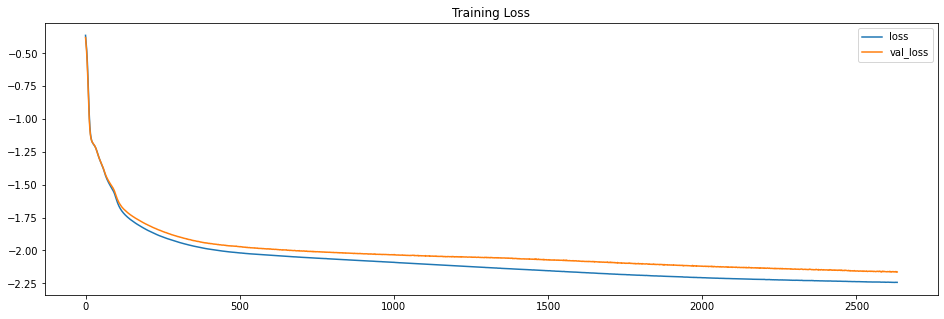

In [93]:
plt.figure(figsize=[16,5])
plt.plot(np.log(hist.history['loss']), label="loss")
plt.plot(np.log(hist.history['val_loss']), label="val_loss")
plt.title('Training Loss')
plt.legend()

Epoch 1/500
20/20 [==============================] - 0s 4ms/step - loss: 0.1065 - val_loss: 0.1154
Epoch 2/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1065 - val_loss: 0.1149
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1065 - val_loss: 0.1155
Epoch 4/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1064 - val_loss: 0.1153
Epoch 5/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1067 - val_loss: 0.1149
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1066 - val_loss: 0.1151
Epoch 7/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1065 - val_loss: 0.1152
Epoch 8/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1064 - val_loss: 0.1150
Epoch 9/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1065 - val_loss: 0.1151
Epoch 10/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1064 - val_loss: 0.1151
Epoch 11/

20/20 [==============================] - 0s 2ms/step - loss: 0.1058 - val_loss: 0.1145
Epoch 84/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1058 - val_loss: 0.1146
Epoch 85/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1058 - val_loss: 0.1145
Epoch 86/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1058 - val_loss: 0.1143
Epoch 87/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1058 - val_loss: 0.1143
Epoch 88/500
20/20 [==============================] - 0s 3ms/step - loss: 0.1059 - val_loss: 0.1145
Epoch 89/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1059 - val_loss: 0.1145
Epoch 90/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1057 - val_loss: 0.1143
Epoch 91/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1060 - val_loss: 0.1144
Epoch 92/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1058 - val_loss: 0.1146
Epoch 93/500


20/20 [==============================] - 0s 3ms/step - loss: 0.1054 - val_loss: 0.1139
Epoch 165/500
20/20 [==============================] - 0s 3ms/step - loss: 0.1053 - val_loss: 0.1139
Epoch 166/500
20/20 [==============================] - 0s 3ms/step - loss: 0.1055 - val_loss: 0.1139
Epoch 167/500
20/20 [==============================] - 0s 3ms/step - loss: 0.1055 - val_loss: 0.1141
Epoch 168/500
20/20 [==============================] - 0s 3ms/step - loss: 0.1054 - val_loss: 0.1139
Epoch 169/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1054 - val_loss: 0.1138
Epoch 170/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1054 - val_loss: 0.1142
Epoch 171/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1054 - val_loss: 0.1139
Epoch 172/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1054 - val_loss: 0.1141
Epoch 173/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1054 - val_loss: 0.1141
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.1051 - val_loss: 0.1139
Epoch 246/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1051 - val_loss: 0.1137
Epoch 247/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 0.1137
Epoch 248/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 0.1137
Epoch 249/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 0.1139
Epoch 250/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1051 - val_loss: 0.1138
Epoch 251/500
20/20 [==============================] - 0s 3ms/step - loss: 0.1050 - val_loss: 0.1140
Epoch 252/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 0.1138
Epoch 253/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1051 - val_loss: 0.1140
Epoch 254/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 0.1136
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 0.1137
Epoch 327/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1047 - val_loss: 0.1134
Epoch 328/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1047 - val_loss: 0.1135
Epoch 329/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1047 - val_loss: 0.1138
Epoch 330/500
20/20 [==============================] - 0s 3ms/step - loss: 0.1046 - val_loss: 0.1135
Epoch 331/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1047 - val_loss: 0.1143
Epoch 332/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1049 - val_loss: 0.1135
Epoch 333/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1048 - val_loss: 0.1137
Epoch 334/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1047 - val_loss: 0.1135
Epoch 335/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1046 - val_loss: 0.1137
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.1044 - val_loss: 0.1133
Epoch 408/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1044 - val_loss: 0.1132
Epoch 409/500
20/20 [==============================] - 0s 3ms/step - loss: 0.1045 - val_loss: 0.1131
Epoch 410/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1043 - val_loss: 0.1133
Epoch 411/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1043 - val_loss: 0.1133
Epoch 412/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1044 - val_loss: 0.1135
Epoch 413/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1043 - val_loss: 0.1134
Epoch 414/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1043 - val_loss: 0.1133
Epoch 415/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1044 - val_loss: 0.1135
Epoch 416/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1044 - val_loss: 0.1135
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 0.1041 - val_loss: 0.1132
Epoch 489/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1040 - val_loss: 0.1130
Epoch 490/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1040 - val_loss: 0.1132
Epoch 491/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1040 - val_loss: 0.1131
Epoch 492/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1041 - val_loss: 0.1130
Epoch 493/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1041 - val_loss: 0.1129
Epoch 494/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1040 - val_loss: 0.1130
Epoch 495/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1040 - val_loss: 0.1131
Epoch 496/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1039 - val_loss: 0.1131
Epoch 497/500
20/20 [==============================] - 0s 2ms/step - loss: 0.1040 - val_loss: 0.1131
Epoc

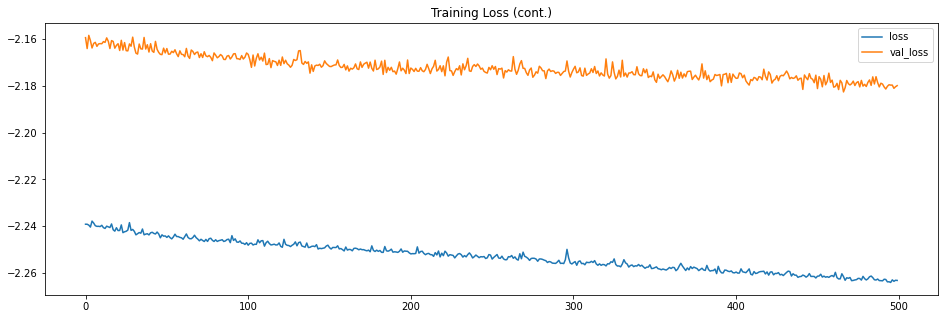

In [94]:
# Continue Training if needed
hist2 = autoencoder.fit(x_train, x_train, epochs=500, batch_size=128, shuffle=True,
                        validation_data=(x_test, x_test), verbose=1, callbacks=[es,])
plt.figure(figsize=[16,5])
plt.plot(np.log(hist2.history['loss']), label="loss")
plt.plot(np.log(hist2.history['val_loss']), label="val_loss")
plt.title('Training Loss (cont.)')
plt.legend()

### Exectute the autoencoder on a single wine to explore the outcome

In [106]:
wine_real = x_train[x_train.index == 'clos_clara_2017_t_gr']

wine_latent = encoder.predict(wine_real)
wine_reconstructed = decoder.predict(wine_latent)
wine_latent.round(2)

1/1 [==============================] - 0s 12ms/step


array([[0.21, 0.09, 0.51, 0.  , 0.45]], dtype=float32)

In [107]:
np.where(wine_reconstructed > 0.5, 1,0) , wine_real.values

(array([[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=int64))

### Find best treshold for binarization and results exploration

In [97]:
from sklearn.metrics import mean_squared_error

x_pred = autoencoder.predict(df_style)

for th in np.arange(0.1, 1, 0.1):
    x_pred_bin = np.where(x_pred > th, 1, 0)
    x_pred_bin = pd.DataFrame(data=x_pred_bin, index=df_style.index, columns=df_style.columns)
    err = mean_squared_error(df_style, x_pred_bin)
    # err = (x_pred_bin - df_style)
    print(th, err)

86/86 [==============================] - 0s 659us/step
0.1 0.08281364636830521
0.2 0.049717993396918556
0.30000000000000004 0.038942131327953045
0.4 0.03562912692589876
0.5 0.03475788701393984
0.6 0.03611060161408658
0.7000000000000001 0.0397560528246515
0.8 0.046748899486427
0.9 0.05814380044020542


As we had expected, the threshold of $0.5$ is the optimal and we can't find a better cutting point to binarize the reconstructed wine styles.

Lets now try to find what each of the latent dimensions mean in terms of styles to find new names.

In [98]:
def vector_to_styles(vec):
    """ Convert hot encoded vector to styles. """
    styles = []
    for idx, val in enumerate(vec):
        if val == 1:
            styles += [df_style.columns[idx],]
    return styles
            

dims = [
    [[1,0,0,0,0,]],
    [[0,1,0,0,0,]],
    [[0,0,1,0,0,]],
    [[0,0,0,1,0,]],
    [[0,0,0,0,1,]],
#     [[0,0,0,0,0,1]],
]
dim_pred = []

for dim in dims:
    dim_pred += [np.where(decoder.predict(dim, verbose=0) >= 0.95, 1, 0)[0],]

for i, dp in enumerate(dim_pred):
    # print(dims[i], vector_to_styles(dp))
    print (', '.join(vector_to_styles(dp)))
    


sabroso, frutal, equilibrado, cítrico, persistente, floral, fresco, taninos, elegante, mineral
frutal, suave, floral, fresco, dulce
corpulento, tostado, amargo, con vejez, cálido, clásico
equilibrado, cítrico, herbal, floral, fresco
corpulento, sabroso, persistente, floral


In [99]:
from ipywidgets import interact

@interact(
    dim1=(0, 1, 0.05),
    dim2=(0, 1, 0.05),
    dim3=(0, 1, 0.05),
    dim4=(0, 1, 0.05),
    dim5=(0, 1, 0.05),
#     dim6=(0, 1, 0.05),
)
def handler(dim1,dim2,dim3,dim4,dim5):
    vec = [[dim1,dim2,dim3,dim4,dim5]]

    vec_pred = np.where(decoder.predict(vec, verbose=0) >= 0.95, 1, 0)[0]
    print (vec)
    print ('\t'.join(vector_to_styles(vec_pred)))

interactive(children=(FloatSlider(value=0.0, description='dim1', max=1.0, step=0.05), FloatSlider(value=0.0, d…

In [151]:
import plotly.graph_objects as go

wine_idx = 50
wine = df_style[wine_idx:wine_idx+1]

wine_latent = encoder.predict(df_style[wine_idx:wine_idx+1])

fig = go.Figure(data=go.Scatterpolar(
    r=wine_latent[0],
    theta=["Afrutado",
"Heterodoxo",
"Sabroso",
"Corpulento",
"Fresco",
"Amargo",],
    fill='toself',
))

fig.update_layout(
  polar=dict(radialaxis=dict(visible=True),  ),
  showlegend=False
)


fig.show()

print(df_style.index[wine_idx])
vector_to_styles(wine.values[0])

1/1 [==============================] - 0s 10ms/step


acustic_rosat_2020_rd


['sabroso', 'frutal', 'herbal']

### Saving Keras model to disk

In [100]:
autoencoder.save('models/autoencoder_d5_0.1131.h5')

In [101]:
df_encoded = pd.DataFrame(
    data=encoder.predict(df_style),
    columns=[
    "Dim1",
    "Dim2",
    "Dim3",
    "Dim4",
    "Dim5",
    ],
    index=df_style.index
)

df_encoded.to_excel('wine_web_dr_encoded_wip.xlsx')

86/86 [==============================] - 0s 645us/step
